# MOP Generation

In [60]:
import numpy as np
import pandas as pd
import os

In [61]:
columns = [
    # --- Scenario Metadata ---
    "Flight_Number",
    "Lead_Pilot",
    "Scenario_within_flight",
    "Scenario_Type",
    "Autonomy_Config",
    "Num_Tactical_Comms",
    "Correct_Sort",
    "Scenario_Start_Time",

    # --- Aircraft State / Performance ---
    "Num_CMs",
    "Lead_Altitude_MSL_ft",
    "Wingman_Altitude_MSL_ft",
    "CM_Airspeed_kt",
    "Lead_Altitude_Deviation_Count",
    "Wingman_Altitude_Deviation_Count",
    "Lead_Altitude_Deviation_Integrated_ft_s",
    "Wingman_Altitude_Deviation_Integrated_ft_s",

    # --- CM Engagement Summary ---
    "Total_CMs_Intercepted",
    "Proportion_CMs_Intercepted",

    # --- Cruise Missile Engagement Details (CM1 - CM10) ---
]

# Dynamically extend for CM1–CM10
for i in range(1, 6):
    columns.extend([
        f"CM{i}_EntId",
        f"CM{i}_Interceptor Role",
        f"CM{i}_Time_to_Intercept_s_from_start",
        f"CM{i}_MOP_Time_to_Intercept_s",
        f"CM{i}_MOP_Time_to_Consent_s",
        f"CM{i}_Airspeed_at_Intercept_kt",
        f"CM{i}_Airspeed_Diff_at_Intercept_kt",
        f"CM{i}_Heading_at_Intercept_deg",
        f"CM{i}_CM_Heading_at_Intercept_deg",
        f"CM{i}_Heading_Diff_at_Intercept_deg",
        f"CM{i}_Altitude_at_Intercept_ft",
        f"CM{i}_Altitude_Offset_at_Intercept_ft",
        f"CM{i}_Bank_Angle_at_Intercept_deg",
        f"CM{i}_Distance_from_CM_at_Intercept_nm",
        f"CM{i}_Aspect_at_MELD_Range_deg"
    ])

# --- SAM Summary ---
columns.extend([
    "Num_SAMs",
    "SAMs_Identified_by_Lead",
    "Proportion_SAMs_Identified",
])

# Dynamically extend for SAM1–SAM10
for i in range(1, 11):
    columns.extend([
        f"SAM{i}_EntId",
        f"SAM{i}_Time_to_ID_s",
    ])

# --- Scenario End ---
columns.extend([
    "Scenario_End_Time",
    "Scenario_Duration_s",
])


In [62]:
results_path = 'Output'
MOP_df = pd.DataFrame(columns=columns)
for file in os.listdir(results_path):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(results_path, file))
        MOP_df = pd.concat([MOP_df, df], ignore_index=True)

In [63]:
# for each row in MOP_df, calculate the average SAM{1-10}_Time_to_ID_s for each entry that is now NaN, and store this as Avg_SAM_ID_Time_s
MOP_df['Avg_SAM_ID_Time_s'] = MOP_df[[f'SAM{i}_Time_to_ID_s' for i in range(1, 11)]].mean(axis=1)

In [64]:
# we do not need the following columns in MOP_df: Scenario_Start_Time, Num_CMs, Lead_Altitude_MSL_ft, Wingman_Altitude_MSL_ft, CM_Airspeed_kt
cols_to_drop = ['Scenario_Start_Time', 'Lead_Altitude_MSL_ft', 'Wingman_Altitude_MSL_ft', 'CM_Airspeed_kt',
                'Total_CMs_Intercepted', 'CM1_EntId', 'Num_SAMs', 'SAMs_Identified_by_Lead', 'Scenario_End_Time']
for i in range(1,6):
    cols_to_drop.extend([f'CM{i}_EntId', f'CM{i}_Airspeed_at_Intercept_kt',
                        f'CM{i}_Heading_at_Intercept_deg', f'CM{i}_CM_Heading_at_Intercept_deg', f'CM{i}_Altitude_at_Intercept_ft',
                        f'CM{i}_Bank_Angle_at_Intercept_deg', f'SAM{i}_EntId'])
for i in range(6,11):
    cols_to_drop.extend([f'SAM{i}_EntId'])

In [65]:
MOP_df = MOP_df.drop(columns=cols_to_drop)

In [66]:
MOP_df['Proportion_SAMs_Identified'] = MOP_df['Proportion_SAMs_Identified'].clip(upper=1)

In [67]:
MOP_df.to_csv('SHADOW_MOPs.csv', index=False)

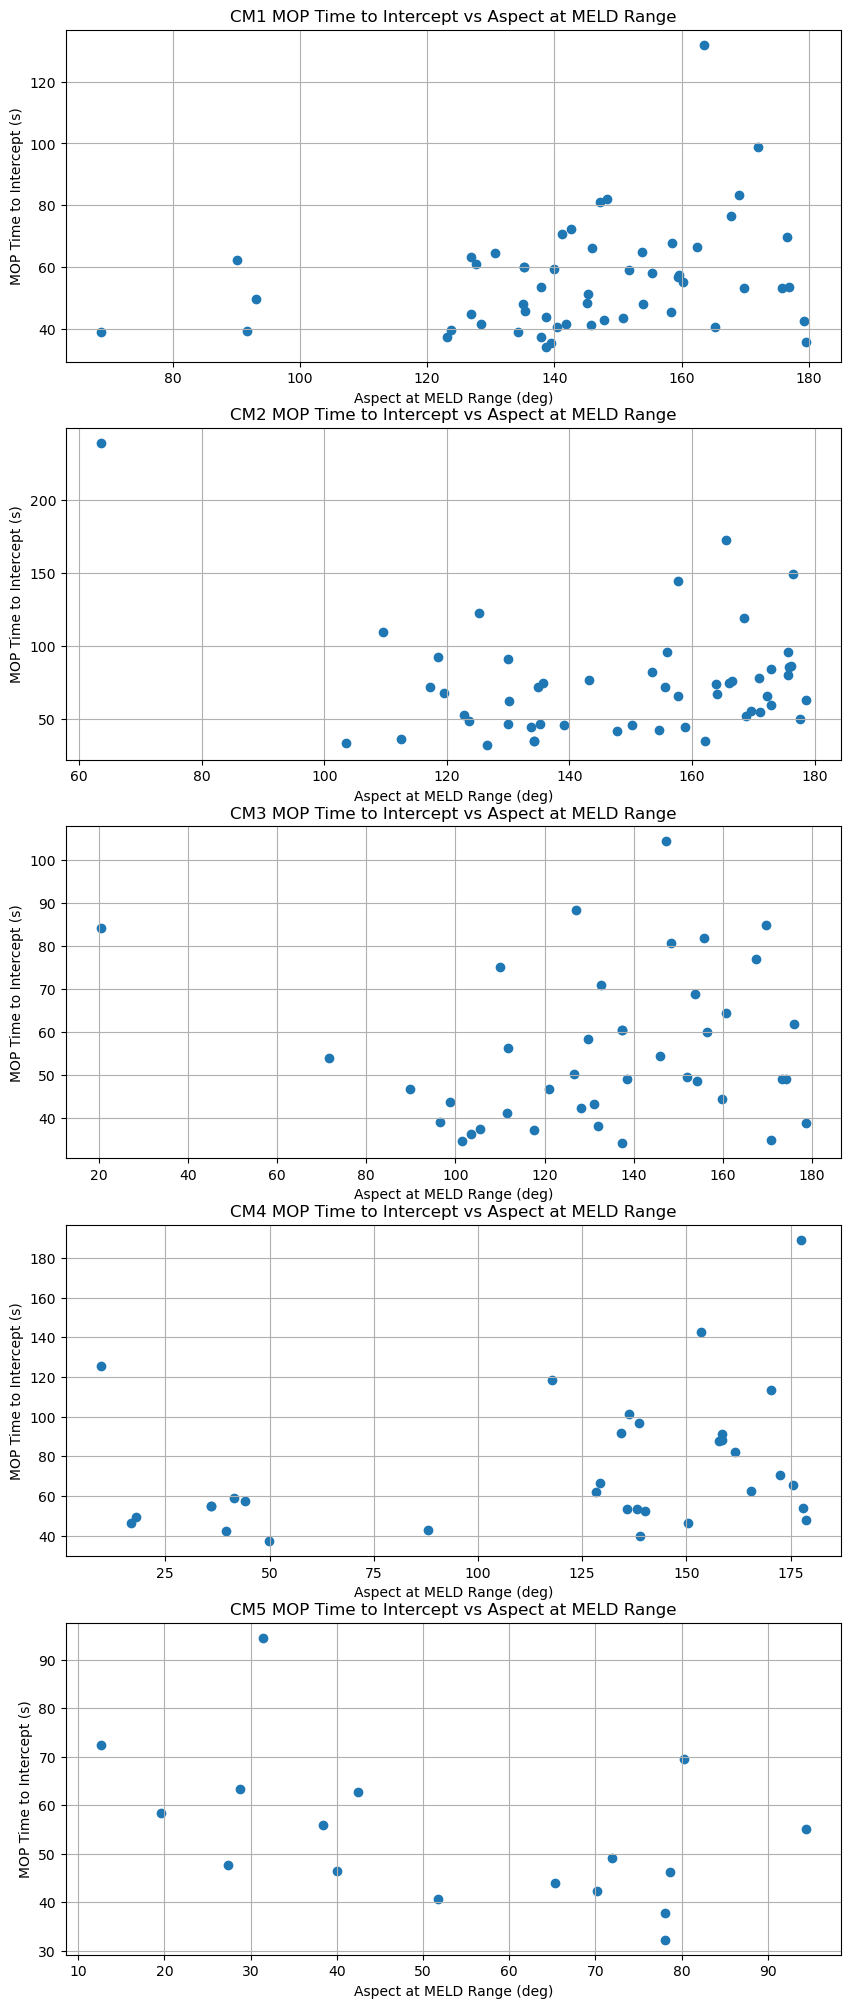

In [68]:
# plot CM1_MOP_Time_to_Intercept_s vs CM1_Aspect_at_MELD_Range_deg using matplotlib for CMs 1-5
import matplotlib.pyplot as plt
fig, axs = plt.subplots(5, 1, figsize=(10, 25))
for i in range(1, 6):
    axs[i-1].scatter(MOP_df[f'CM{i}_Aspect_at_MELD_Range_deg'], MOP_df[f'CM{i}_MOP_Time_to_Intercept_s'])
    axs[i-1].set_title(f'CM{i} MOP Time to Intercept vs Aspect at MELD Range')
    axs[i-1].set_xlabel('Aspect at MELD Range (deg)')
    axs[i-1].set_ylabel('MOP Time to Intercept (s)')
    axs[i-1].grid(True)